**5장 – 서포트 벡터 머신**

_이 노트북은 5장에 있는 모든 샘플 코드와 연습문제 해답을 가지고 있습니다._

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/05_support_vector_machines.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [2]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "svm"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 5.1 선형 SVM 분류

아래의 코드는 그래프를 그리는 코드들이며,
SVM의 예시들을 표시한다.

예시 코드에서 데이터들은 선형적으로 분류되며, 점선으로 표시되는 결정 경계또한 표시된다.

SVM은 실선과 점선으로 이루어진 가장 넓은 도로를 찾는것으로 해석할 수 있으며, 때문에 __라지 마진 분류__라고도 한다.

여기서 모든 샘플들이 도로 바깥에 분류되어 있을 경우, 이를 __하드 마진 분류__ 라고 한다.

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

# SVM 분류 모델
svm_clf = SVC(kernel="linear", C=float("inf"))
svm_clf.fit(X, y)

SVC(C=inf, kernel='linear')

그림 저장: large_margin_classification_plot


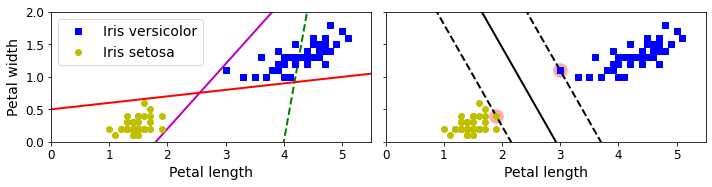

In [ ]:
# 나쁜 모델
x0 = np.linspace(0, 5.5, 200)
pred_1 = 5*x0 - 20
pred_2 = x0 - 1.8
pred_3 = 0.1 * x0 + 0.5

def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # 결정 경계에서 w0*x0 + w1*x1 + b = 0 이므로
    # => x1 = -w0/w1 * x0 - b/w1
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]

    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin

    svs = svm_clf.support_vectors_
    plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(x0, pred_1, "g--", linewidth=2)
plt.plot(x0, pred_2, "m-", linewidth=2)
plt.plot(x0, pred_3, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plot_svc_decision_boundary(svm_clf, 0, 5.5)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.xlabel("Petal length", fontsize=14)
plt.axis([0, 5.5, 0, 2])

save_fig("large_margin_classification_plot")
plt.show()

**<그림 5-2. 특성 스케일에 따른 민감성> 생성 코드**

그림 저장: sensitivity_to_feature_scales_plot


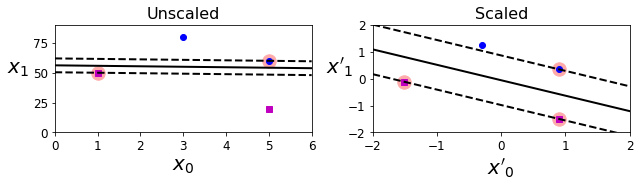

In [ ]:
Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])
svm_clf = SVC(kernel="linear", C=100)
svm_clf.fit(Xs, ys)

plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, 0, 6)
plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)
svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")
plot_svc_decision_boundary(svm_clf, -2, 2)
plt.xlabel("$x'_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

save_fig("sensitivity_to_feature_scales_plot")


## 5.1.1소프트 마진 분류

__하드마진이 가지는 문제점 : __
- 데이터가 선형적으로 구분되어야 제대로 작동한다
- 이상치에 민감하다

아래의 코드는 __하드마진을 가질 수 없거나__(왼쪽), __일반화가 잘 되지 않는 하드마진 분류__(오른쪽) 의 경우를 나타낸다.

그림 저장: sensitivity_to_outliers_plot


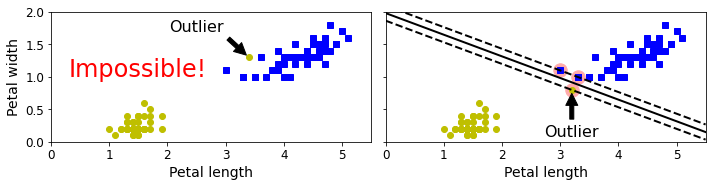

In [ ]:
X_outliers = np.array([[3.4, 1.3], [3.2, 0.8]])
y_outliers = np.array([0, 0])
Xo1 = np.concatenate([X, X_outliers[:1]], axis=0)
yo1 = np.concatenate([y, y_outliers[:1]], axis=0)
Xo2 = np.concatenate([X, X_outliers[1:]], axis=0)
yo2 = np.concatenate([y, y_outliers[1:]], axis=0)

svm_clf2 = SVC(kernel="linear", C=10**9)
svm_clf2.fit(Xo2, yo2)

fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(Xo1[:, 0][yo1==1], Xo1[:, 1][yo1==1], "bs")
plt.plot(Xo1[:, 0][yo1==0], Xo1[:, 1][yo1==0], "yo")
plt.text(0.3, 1.0, "Impossible!", fontsize=24, color="red")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[0][0], X_outliers[0][1]),
             xytext=(2.5, 1.7),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

plt.sca(axes[1])
plt.plot(Xo2[:, 0][yo2==1], Xo2[:, 1][yo2==1], "bs")
plt.plot(Xo2[:, 0][yo2==0], Xo2[:, 1][yo2==0], "yo")
plot_svc_decision_boundary(svm_clf2, 0, 5.5)
plt.xlabel("Petal length", fontsize=14)
plt.annotate("Outlier",
             xy=(X_outliers[1][0], X_outliers[1][1]),
             xytext=(3.2, 0.08),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=16,
            )
plt.axis([0, 5.5, 0, 2])

save_fig("sensitivity_to_outliers_plot")
plt.show()

위의 문제에 대한 해결을 위해
__도로의 폭을 가능한 한 넓게 유지__하는 것과 __마진 오류__(샘플이 도로 중간 혹은 반대쪽에 있는 경우) 사이의 적절한 균형을 잡아줘야 할 필요가 있다.

이것을 __소프트 마진 분류__ 라 한다.

- SVM 모델의 하이퍼 파라미터 C를 통해 도로의 넓이를 정할 수 있다.
(C값이 작을수록 도로가 넓음)

- C를 감소시켜 모델을 규제할 수 있다

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42)),
    ])

svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc', LinearSVC(C=1, loss='hinge', random_state=42))])

In [ ]:
svm_clf.predict([[5.5, 1.7]])

array([1.])

**<그림 5-4. 넓은 마진(왼쪽) 대 적은 마진 오류(오른쪽)> 생성 코드**

In [ ]:
scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge", random_state=42)
svm_clf2 = LinearSVC(C=100, loss="hinge", random_state=42)
# random_state = 42인 상태에서 힌지 오차를 사용하는 SVC를 사용한다.
# 여기서 하이퍼 파라미터 C를 변경하여 다른 그래프를 만드는 것을 학인할 수 있다.


scaled_svm_clf1 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf1),
    ])
scaled_svm_clf2 = Pipeline([
        ("scaler", scaler),
        ("linear_svc", svm_clf2),
    ])

scaled_svm_clf1.fit(X, y)
scaled_svm_clf2.fit(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('scaler', StandardScaler()),
                ('linear_svc',
                 LinearSVC(C=100, loss='hinge', random_state=42))])

In [ ]:
# 스케일되지 않은 파라미터로 변경
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

# 서포트 벡터 찾기 (libsvm과 달리 liblinear 라이브러리에서 제공하지 않기 때문에 
# LinearSVC에는 서포트 벡터가 저장되어 있지 않습니다.)
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

그림 저장: regularization_plot


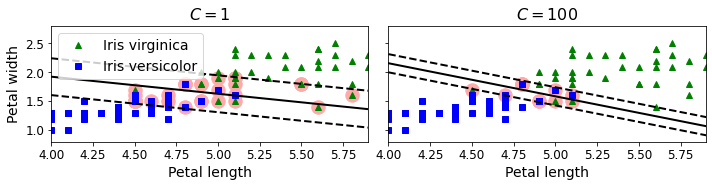

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10,2.7), sharey=True)

plt.sca(axes[0])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs", label="Iris versicolor")
plot_svc_decision_boundary(svm_clf1, 4, 5.9)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.title("$C = {}$".format(svm_clf1.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

plt.sca(axes[1])
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 5.99)
plt.xlabel("Petal length", fontsize=14)
plt.title("$C = {}$".format(svm_clf2.C), fontsize=16)
plt.axis([4, 5.9, 0.8, 2.8])

save_fig("regularization_plot")

보통 마진 오류는 적은것이 좋으나, 왼쪽 그래프가 더 일반화 되기에 좋다고 판단할 수 있다.

# 5.2 비선형 SVM 분류

하나의 특성만으론 분류를 할 수 없으나, 두개 이상의 특성을 사용하여 분류할 수 있는 경우도 존재한다. 

아래의 코드는 특성 x2를 하나 더 추가하여 분류한 결과를 표현하는 코드이다.

그림 저장: higher_dimensions_plot


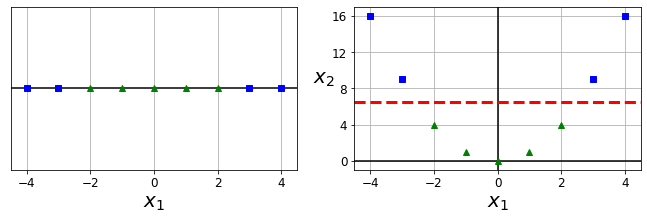

In [ ]:
X1D = np.linspace(-4, 4, 9).reshape(-1, 1)
# -4부터 4까지, 9칸을 사용한다.
X2D = np.c_[X1D, X1D**2]
# 자료의 위치는 (x, x^2) 에 해당한다. 세번째 원소의 경우 (-2, 4) 위치에 점이 찍히게 된다. 
y = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])
#1은 초록 삼각형, 0은 파랑 사각형으로 표현된다.

plt.figure(figsize=(10, 3))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.plot(X1D[:, 0][y==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][y==1], np.zeros(5), "g^")
plt.gca().get_yaxis().set_ticks([])
plt.xlabel(r"$x_1$", fontsize=20)
plt.axis([-4.5, 4.5, -0.2, 0.2])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(X2D[:, 0][y==0], X2D[:, 1][y==0], "bs")
plt.plot(X2D[:, 0][y==1], X2D[:, 1][y==1], "g^")
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"$x_2$  ", fontsize=20, rotation=0) #y축에 x2 특성이 추가되었다.
plt.gca().get_yaxis().set_ticks([0, 4, 8, 12, 16])
plt.plot([-4.5, 4.5], [6.5, 6.5], "r--", linewidth=3)
plt.axis([-4.5, 4.5, -1, 17])

plt.subplots_adjust(right=1)

save_fig("higher_dimensions_plot", tight_layout=False)
plt.show()

X1만 표현한 경우, 두 가지 타입의 데이터를 분류할 수 없었으나, X2를 포함하여 표현한 경우 X2값을 이용해 데이터를 둘로 분류할 수 있었다는것을 확인할 수 있다.

이처럼 하나의 특성이 아닌 둘 이상을 이용하여 SVM분류를 할 수 있을것이며, 이를 비선형 SVM 분류라고 한다.

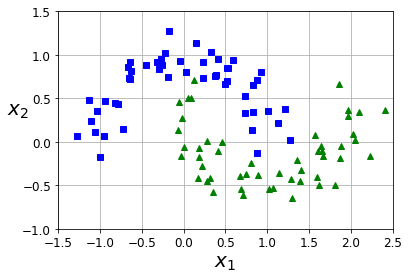

In [ ]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)
# 두 개의 반달모양을 가지는 데이터셋 moons를 sklearn의 make_moons를 이용하여 만든다.


def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    # y label이 0인 데이터들 X의 n번째 원소를 (X[:, 0], X[:,n]) 위치에 파랑 정사각형의 형태로 표시한다.
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    # y label이 1인 데이터들 X의 n번째 원소를 (X[:, 0], x[:, N]) 위치에 녹색 삼각형의 형태로 표시한다.

    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()





**위의 데이터를 사용하여 비선형으로 분류하는 SVM을 만든다.**

이를 위해선 

- PolynomialFeatures 변환기
- StandardScaler, LinearSVC

를 연결한 Pipeline을 사용한다.

In [ ]:
from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),                # degree=3으로 사용하여 훈련세트의 각 특성을 3차항으로 만들어 추가하는 다항 변환기 PolynomialFeatures를 연결한다.
        ("scaler", StandardScaler()),                                   # scaler로 StandardScaler를 연결
        ("svm_clf", LinearSVC(C=10, loss="hinge", random_state=42))     # 힌지 오류를 사용하며 C값이 10인 LinearSVC를 svm_clf로 연결 
    ])


polynomial_svm_clf.fit(X, y)


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', LinearSVC(C=10, loss='hinge', random_state=42))])

In [ ]:
#위의 X1D를 이용하여 PolynomialFeatures의 Degree 3을 체감해보자.

for data in X1D:
  print(data)
#X1D의 원형을 모두 프린트한다.

print("\n" + "/" * 30 + "\n")
X_transformed = PolynomialFeatures(degree=3, include_bias=False).fit_transform(X1D) 
# 편향을 나타내는 include_bias는 false로 설정하고, fit_transform을 통해 변환시켰다.

for data in X_transformed:
  print(data)

#1차항만 존재하던 X1D가 2차항, 3차항이 추가되었음을 확인할 수 있다.

[-4.]
[-3.]
[-2.]
[-1.]
[0.]
[1.]
[2.]
[3.]
[4.]

//////////////////////////////

[ -4.  16. -64.]
[ -3.   9. -27.]
[-2.  4. -8.]
[-1.  1. -1.]
[0. 0. 0.]
[1. 1. 1.]
[2. 4. 8.]
[ 3.  9. 27.]
[ 4. 16. 64.]


**<그림 5-6. 다항 특성을 사용한 선형 SVM 분류기> 생성 코드**

그림 저장: moons_polynomial_svc_plot


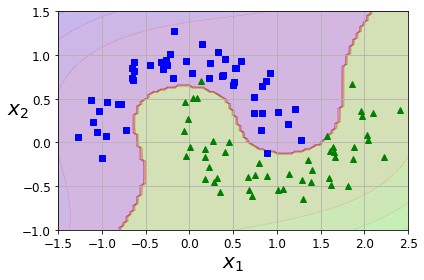

In [ ]:
def plot_predictions(clf, axes): #prediction을 그래프에 표시하기 위한 코드
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])

save_fig("moons_polynomial_svc_plot")
plt.show()

## 5.2.1 다항식 커널 

다항식 특성을 추가하는 것은 대부분의 경우에 잘 작동하지만 
<br>__낮은__ 차수의 다항식은 __복잡한 데이터 셋을 잘 표현하지 못하고__,
<br>__높은__ 차수의 다항식은 __모델이 매우 느려진다__는 문제를 가진다.

이 부분에 대해, 다항을 많이 추가한 효과를 다항을 추가하지 않고 얻는
<br>__커널 트릭__ 이라는 수학적 기교가 존재한다.
<br><br>

아래의 코드는 커널 트릭을 사용한 SVM 분류기를 통해 훈련시키는 것을 나타내고 있다.

In [ ]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
    ])
# StandardScaler 와 kernel 트릭을 사용하는 SVC 모델을 연결한 파이프라인을 훈련에 사용한다.
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

**<그림 5-7. 다항식 커널을 사용한 SVM 분류기> 생성 코드**

아래의 코드는 커널 트릭을 사용해 SVM 훈련한 SVM 분류기를 plot을 이용해 표시하는 코드이다.


다항식의 차수를 늘리는 것 처럼 coef0를 통해 적합도를 올릴지, 낮출지를 결정할 수 있으며 
<br>coef를 100으로 설정한 예시를 추가로 표시해 비교한다.


In [ ]:
poly100_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=10, coef0=100, C=5))
    ])

# 특성을 줄이는 것 처럼, 과대적합일 경우 차수를 줄여야 하는데, cㅐef0이 커널 트릭에서 차수를 설정하는 것에 해당한다.
# copf0를 찾기 위해선 그리드 탐색을 사용하는 것이 가장 일반적이다.

poly100_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, degree=10, kernel='poly'))])

그림 저장: moons_kernelized_polynomial_svc_plot


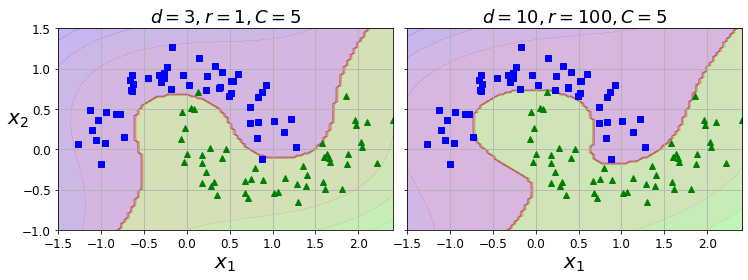

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(10.5, 4), sharey=True)
#plot_predictions를 이용해 예측결과를 출력한다. 
#1은 coef가 0인 경우의 예측, 2는 coef가 100인 경우의 예측을 출력한다.

#1
plt.sca(axes[0])
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=3, r=1, C=5$", fontsize=18)

#2
plt.sca(axes[1])
plot_predictions(poly100_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])
plt.title(r"$d=10, r=100, C=5$", fontsize=18)
plt.ylabel("")

save_fig("moons_kernelized_polynomial_svc_plot")
plt.show()

## 5.2.2 유사도 특성

비선형 특성을 다루는 또 다른 기법 : __유사도 함수__를 계산한 특성을 추가한다

앞의 X1D를 이용하자. 여기서 두 개의 __랜드마크__ $x_1 = -2와 x_1= 1$을 추가한다.
<br>이제 $\gamma$ = 0.03인 __가우시안 방사 기저 함수 (RBF)__를 유사도 함수로 정의하여 각 랜드마크에 대해 계산하고 $x_2, x_3$라는 특성을 추가하자

- $x_2$: 랜드마크 $x_1 = -2$에 대해 RBF를 계산한 경우
- $x_3$: 랜드마크 $x_2 = 1$에 대해 RBF를 계산한 경우

**<그림 5-8. 가우시안 RBF를 사용한 유사도 특성> 생성 코드**

**식 5-1: 가우시안 RBF**

$
{\displaystyle \phi_{\gamma}(\mathbf{x}, \boldsymbol{\ell})} = {\displaystyle \exp({\displaystyle -\gamma \left\| \mathbf{x} - \boldsymbol{\ell} \right\|^2})}
$

그림 저장: kernel_method_plot


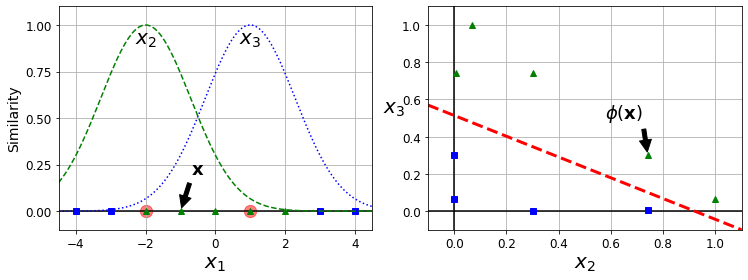

In [ ]:
def gaussian_rbf(x, landmark, gamma):
    return np.exp(-gamma * np.linalg.norm(x - landmark, axis=1)**2)

#위에 적혀있는 가우시안 RBF 식을 그대로 코드로 옮겨놓았다.

gamma = 0.3

x1s = np.linspace(-4.5, 4.5, 200).reshape(-1, 1)
# 랜드마크에 대한 유사도를 그리기 위한 지점들을 가져온다. -4.5에서 4.5까지 200개의 균등한 거리를 가진 지점을 가져온다.
x2s = gaussian_rbf(x1s, -2, gamma)
x3s = gaussian_rbf(x1s, 1, gamma)

#200개의 지점과 x2, x3와 관련한 랜드마크의 유사도를 측정하여 값을 만든다.

XK = np.c_[gaussian_rbf(X1D, -2, gamma), gaussian_rbf(X1D, 1, gamma)]
yk = np.array([0, 0, 1, 1, 1, 1, 1, 0, 0])

plt.figure(figsize=(10.5, 4))

plt.subplot(121)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.scatter(x=[-2, 1], y=[0, 0], s=150, alpha=0.5, c="red")
#일부 지점들을 표시하기 위한 빨간 점
plt.plot(X1D[:, 0][yk==0], np.zeros(4), "bs")
plt.plot(X1D[:, 0][yk==1], np.zeros(5), "g^")
# y label이 0인 데이터는 파란 사각형, 1인 데이터는 녹색 사각형으로 표시한다.
plt.plot(x1s, x2s, "g--")
plt.plot(x1s, x3s, "b:")
# 위에서 계산한 유사도를 점선 그래프로 표시한다. x2는 --, b는 점선으로 그려진다.

#이 그래프는 선형 그래프 X1D와 그 위의 유사도에 대해 표시한다.

plt.gca().get_yaxis().set_ticks([0, 0.25, 0.5, 0.75, 1])
plt.xlabel(r"$x_1$", fontsize=20)
plt.ylabel(r"Similarity", fontsize=14)
plt.annotate(r'$\mathbf{x}$',
             xy=(X1D[3, 0], 0),
             xytext=(-0.5, 0.20),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.text(-2, 0.9, "$x_2$", ha="center", fontsize=20)
plt.text(1, 0.9, "$x_3$", ha="center", fontsize=20)
plt.axis([-4.5, 4.5, -0.1, 1.1])

plt.subplot(122)
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.plot(XK[:, 0][yk==0], XK[:, 1][yk==0], "bs")
plt.plot(XK[:, 0][yk==1], XK[:, 1][yk==1], "g^")
#label이 0이라면 파란 사각형, 1히라면 녹색 삼각형으로 표시한다.
#위 그래프의 x좌표, y좌표는 x2, x3이다.(계산된 유사도)

plt.xlabel(r"$x_2$", fontsize=20)
plt.ylabel(r"$x_3$  ", fontsize=20, rotation=0)
plt.annotate(r'$\phi\left(\mathbf{x}\right)$',
             xy=(XK[3, 0], XK[3, 1]),
             xytext=(0.65, 0.50),
             ha="center",
             arrowprops=dict(facecolor='black', shrink=0.1),
             fontsize=18,
            )
plt.plot([-0.1, 1.1], [0.57, -0.1], "r--", linewidth=3)
plt.axis([-0.1, 1.1, -0.1, 1.1])
    
plt.subplots_adjust(right=1)

save_fig("kernel_method_plot")
plt.show()

위의 데이터 X1D는 특성이 하나인 데이터로, 선형으로 구분할 수 없는 데이터이나<br>RBF를 통해 특성을 추가할 경우 구분이 가능해짐을 알 수 있다. 

In [ ]:
x1_example = X1D[3, 0]
for landmark in (-2, 1):
    k = gaussian_rbf(np.array([[x1_example]]), np.array([[landmark]]), gamma)
    print("Phi({}, {}) = {}".format(x1_example, landmark, k))

    #위 코드는 -2 값에 대한 RBF 계산 예시이다.

Phi(-1.0, -2) = [0.74081822]
Phi(-1.0, 1) = [0.30119421]


## 5.2.3 가우시안 RBF 커널

가우시안 RBF를 이용한 유사도 특성 방식에도 커널트릭이 사용될 수 있다.
<br>아래 예제에선 가우시한 RBF 커널을 사용한 SVC 모델을 시도한다.

**다음 코드 예제:**

In [ ]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
    ])
# scaler로는 StandardScaler를,
# 다항 변환이 아닌, rbf 유사도 특성을 사용하는 커널을 설정한 SVC 모델을 Pipeline에 연결한다.
rbf_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=0.001, gamma=5))])

SVC에 사용되는 하이퍼 파라미터 C와 가우시안 RBF에 사용되는 파라미터 $\gamma$를 조절할 수 있다. 
<br>$\gamma$ 또한 값이 클 수록 적합도가 높아지며, 값이 작을 수록 적합도가 낮아진다.
<br>이는 SVC의 C와 공유하는 매우 비슷한 특징이다.


<br> 
아래 코드는 $\gamma$와 SVC의 C를 변경해가며 사용하고, 결과를 비교하는 코드이다.

**<그림 5-9. RBF 커널을 사용한 SVM 분류기> 생성 코드**

그림 저장: moons_rbf_svc_plot


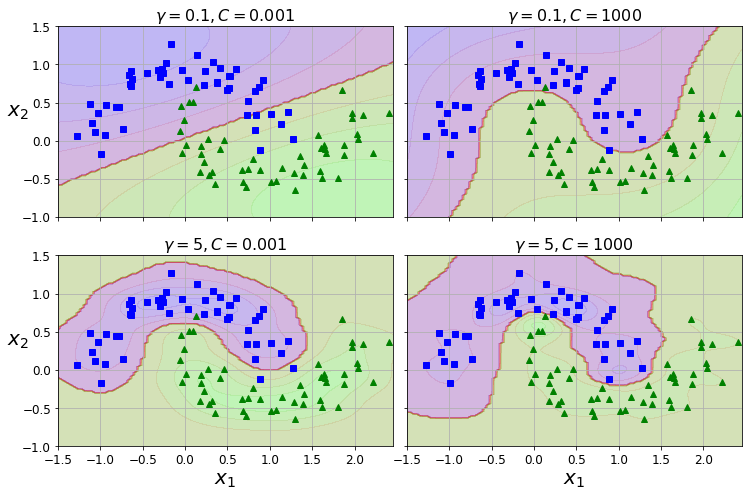

In [ ]:
from sklearn.svm import SVC

gamma1, gamma2 = 0.1, 5
C1, C2 = 0.001, 1000

#1번파라미터는 작은 값을 사용하며, 2번 파라미터는 상대적으로 큰 값을 사용한다.
hyperparams = (gamma1, C1), (gamma1, C2), (gamma2, C1), (gamma2, C2)

#hyper params에 감마와 C 값을 넣어 for문을 통해 각각 다른 경우의 모델을 만든다.

svm_clfs = []
for gamma, C in hyperparams:
    rbf_kernel_svm_clf = Pipeline([
            ("scaler", StandardScaler()),
            ("svm_clf", SVC(kernel="rbf", gamma=gamma, C=C))
        ])
    rbf_kernel_svm_clf.fit(X, y)
    svm_clfs.append(rbf_kernel_svm_clf)

# 각각 다른 경우의 모델을 만드는 부분, svm_clf에 추가한다.

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10.5, 7), sharex=True, sharey=True)

for i, svm_clf in enumerate(svm_clfs):
    plt.sca(axes[i // 2, i % 2])
    plot_predictions(svm_clf, [-1.5, 2.45, -1, 1.5])
    plot_dataset(X, y, [-1.5, 2.45, -1, 1.5])
    gamma, C = hyperparams[i]
    plt.title(r"$\gamma = {}, C = {}$".format(gamma, C), fontsize=16)
    if i in (0, 1):
        plt.xlabel("")
    if i in (1, 3):
        plt.ylabel("")

save_fig("moons_rbf_svc_plot")
plt.show()

이 외의 커널은 거의 사용되지 않으나, 일부 자료형에 특화된 커널이 존재한다.

ex) __문자열 커널__ ( __문자열 서브시퀀스 커널 __ 혹은 __레벤슈타일 거리__ 기반 커널 ) : 텍스트 문서나 DNA 서열을 분류할 때 사용된다.

# 5.3 SVM 회귀

SVM은 다목적으로 사용할 수 있는 모델인 만큼, 선형, 비선형 분류에도 사용할 수 있다.

SVM을 회귀에 적용하시 위해 목표를 반대로 설정한다.

__제한된 마진오류 안__ 에서 __도로안에 최대한 많은 샘플__들어가도록
하는것이 SVM회귀의 목표이다


아래의 코드는 마진의 크기에 따라 다르게 나타나는것을 보여주며,
마진 안에서 훈련샘플이 추가되어도 모델의 예측에 영향이 없기 때문에 __민감하지 않다__고 말한다.

In [4]:
np.random.seed(42)
#랜덤으로 나오는 변수의 경우를 고정한다.
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()


**다음 코드 예제:**

In [5]:
from sklearn.svm import LinearSVR

svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

LinearSVR(epsilon=1.5, random_state=42)

SVR = Support Vector Regression.

Machine이 Regression으로 바뀌었음을 알 수 있다.
<br>SVR은 SVM의 회귀버전이라고 생각하면 된다.

Linear SVR과 Linear SVM의 관계도 마찬가지.

**<그림 5-10. SVM 회귀> 생성 코드**

SVM 회귀이기 때문에, SVM의 회귀버전인 SVR을 사용한다.

In [ ]:
svm_reg1 = LinearSVR(epsilon=1.5, random_state=42)
svm_reg2 = LinearSVR(epsilon=0.5, random_state=42)
svm_reg1.fit(X, y)
svm_reg2.fit(X, y)

def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

eps_x1 = 1
eps_y_pred = svm_reg1.predict([[eps_x1]])

그림 저장: svm_regression_plot


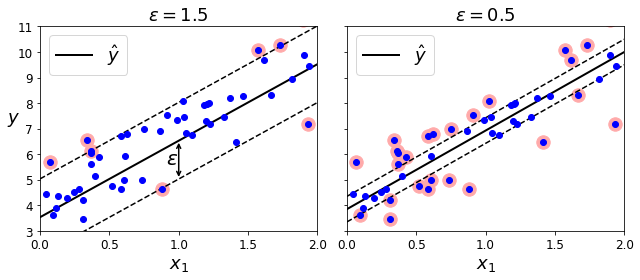

In [ ]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_reg1, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
#plt.plot([eps_x1, eps_x1], [eps_y_pred, eps_y_pred - svm_reg1.epsilon], "k-", linewidth=2)
plt.annotate(
        '', xy=(eps_x1, eps_y_pred), xycoords='data',
        xytext=(eps_x1, eps_y_pred - svm_reg1.epsilon),
        textcoords='data', arrowprops={'arrowstyle': '<->', 'linewidth': 1.5}
    )
plt.text(0.91, 5.6, r"$\epsilon$", fontsize=20)
plt.sca(axes[1])
plot_svm_regression(svm_reg2, X, y, [0, 2, 3, 11])
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon), fontsize=18)
save_fig("svm_regression_plot")
plt.show()

In [ ]:
np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값이 될 `gamma="scale"`으로 지정했습니다.

**다음 코드 예제:**

비선형 회귀 작업을 실행하기 위해선 커널 SVM 모델을 사용한다.

SVM에서 사용할 수 있었던 커널 트릭을 SVR에서도 사용할 수 있으며, 다음 코드에선 다항 추가에 해당하는 커널 트릭을 사용한다.



In [ ]:
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

SVR(C=100, degree=2, kernel='poly')

**<그림 5-11. 2차 다항 커널을 사용한 SVM 회귀> 생성 코드**

위 코드에선 2차 다항 커널 트릭을 사용한 2개의 SVR을 보여주고 비교한다. 

C 값에 따라 규제의 양이 다르다는것을 나타내는데,C 값이 작을수록 더욱 큰 규제를 가진다.

In [ ]:
from sklearn.svm import SVR

svm_poly_reg1 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg2 = SVR(kernel="poly", degree=2, C=0.01, epsilon=0.1, gamma="scale")
svm_poly_reg1.fit(X, y)
svm_poly_reg2.fit(X, y)

SVR(C=0.01, degree=2, kernel='poly')

그림 저장: svm_with_polynomial_kernel_plot


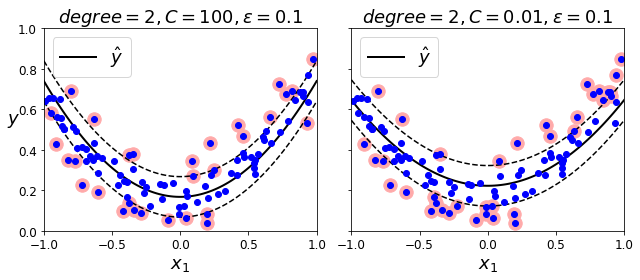

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(9, 4), sharey=True)
plt.sca(axes[0])
plot_svm_regression(svm_poly_reg1, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon), fontsize=18)
plt.ylabel(r"$y$", fontsize=18, rotation=0)
plt.sca(axes[1])
plot_svm_regression(svm_poly_reg2, X, y, [-1, 1, 0, 1])
plt.title(r"$degree={}, C={}, \epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon), fontsize=18)
save_fig("svm_with_polynomial_kernel_plot")
plt.show()

# 5.4 SVM 이론

## 5.4.1 결정 함수와 예측

**식 5-2: 선형 SVM 분류기의 예측**

$
\hat{y} = \begin{cases}
 0 & \mathbf{w}^T \mathbf{x} + b < 0 \text{ 일 때}, \\
 1 & \mathbf{w}^T \mathbf{x} + b \geq 0 \text{ 일 때}
\end{cases}
$

**<그림 5-12. iris 데이터셋의 결정 함수> 생성 코드**

In [ ]:
iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64)  # Iris virginica

그림 저장: iris_3D_plot


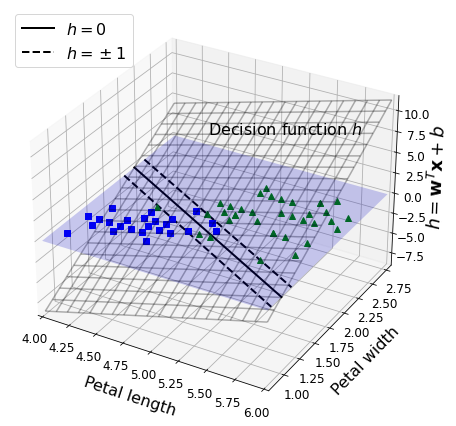

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3D_decision_function(ax, w, b, x1_lim=[4, 6], x2_lim=[0.8, 2.8]):
    x1_in_bounds = (X[:, 0] > x1_lim[0]) & (X[:, 0] < x1_lim[1])
    X_crop = X[x1_in_bounds]
    y_crop = y[x1_in_bounds]
    x1s = np.linspace(x1_lim[0], x1_lim[1], 20)
    x2s = np.linspace(x2_lim[0], x2_lim[1], 20)
    x1, x2 = np.meshgrid(x1s, x2s)
    xs = np.c_[x1.ravel(), x2.ravel()]
    df = (xs.dot(w) + b).reshape(x1.shape)
    m = 1 / np.linalg.norm(w)
    boundary_x2s = -x1s*(w[0]/w[1])-b/w[1]
    margin_x2s_1 = -x1s*(w[0]/w[1])-(b-1)/w[1]
    margin_x2s_2 = -x1s*(w[0]/w[1])-(b+1)/w[1]
    ax.plot_surface(x1s, x2, np.zeros_like(x1),
                    color="b", alpha=0.2, cstride=100, rstride=100)
    ax.plot(x1s, boundary_x2s, 0, "k-", linewidth=2, label=r"$h=0$")
    ax.plot(x1s, margin_x2s_1, 0, "k--", linewidth=2, label=r"$h=\pm 1$")
    ax.plot(x1s, margin_x2s_2, 0, "k--", linewidth=2)
    ax.plot(X_crop[:, 0][y_crop==1], X_crop[:, 1][y_crop==1], 0, "g^")
    ax.plot_wireframe(x1, x2, df, alpha=0.3, color="k")
    ax.plot(X_crop[:, 0][y_crop==0], X_crop[:, 1][y_crop==0], 0, "bs")
    ax.axis(x1_lim + x2_lim)
    ax.text(4.5, 2.5, 3.8, "Decision function $h$", fontsize=16)
    ax.set_xlabel(r"Petal length", fontsize=16, labelpad=10)
    ax.set_ylabel(r"Petal width", fontsize=16, labelpad=10)
    ax.set_zlabel(r"$h = \mathbf{w}^T \mathbf{x} + b$", fontsize=18, labelpad=5)
    ax.legend(loc="upper left", fontsize=16)

fig = plt.figure(figsize=(11, 6))
ax1 = fig.add_subplot(111, projection='3d')
plot_3D_decision_function(ax1, w=svm_clf2.coef_[0], b=svm_clf2.intercept_[0])

save_fig("iris_3D_plot")
plt.show()

## 5.4.2 목적 함수

**<그림 5-13. 가중치 벡터가 작을수록 마진은 커집니다> 생성 코드**

그림 저장: small_w_large_margin_plot


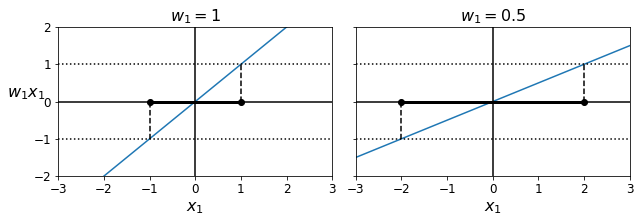

In [ ]:
def plot_2D_decision_function(w, b, ylabel=True, x1_lim=[-3, 3]):
    x1 = np.linspace(x1_lim[0], x1_lim[1], 200)
    y = w * x1 + b
    m = 1 / w

    plt.plot(x1, y)
    plt.plot(x1_lim, [1, 1], "k:")
    plt.plot(x1_lim, [-1, -1], "k:")
    plt.axhline(y=0, color='k')
    plt.axvline(x=0, color='k')
    plt.plot([m, m], [0, 1], "k--")
    plt.plot([-m, -m], [0, -1], "k--")
    plt.plot([-m, m], [0, 0], "k-o", linewidth=3)
    plt.axis(x1_lim + [-2, 2])
    plt.xlabel(r"$x_1$", fontsize=16)
    if ylabel:
        plt.ylabel(r"$w_1 x_1$  ", rotation=0, fontsize=16)
    plt.title(r"$w_1 = {}$".format(w), fontsize=16)

fig, axes = plt.subplots(ncols=2, figsize=(9, 3.2), sharey=True)
plt.sca(axes[0])
plot_2D_decision_function(1, 0)
plt.sca(axes[1])
plot_2D_decision_function(0.5, 0, ylabel=False)
save_fig("small_w_large_margin_plot")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)] # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64) # Iris virginica

svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X, y)
svm_clf.predict([[5.3, 1.3]])

array([1.])

**식 5-3: 하드 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b}{\operatorname{minimize}}\quad{\frac{1}{2}\mathbf{w}^T \mathbf{w}} \\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

## 5.4.3 콰드라틱 프로그래밍

하드 마진과 소프트 마진 문제처럼 __선형적인 제약 조건이 있는 볼록 함수의 이차 최적화 문제__를 __콰드라틱 프로그래밍(QP)__ 문제라고 한다.

아래의 식은 QP 문제의 일반적인 공식이다.

**식 5-4: 소프트 마진 선형 SVM 분류기 목적 함수**

$
\begin{split}
&\underset{\mathbf{w}, b, \mathbf{\zeta}}{\operatorname{minimize}}\quad{\dfrac{1}{2}\mathbf{w}^T \mathbf{w} + C \sum\limits_{i=1}^m{\zeta^{(i)}}}\\
&\text{subject to} \quad t^{(i)}(\mathbf{w}^T \mathbf{x}^{(i)} + b) \ge 1 - \zeta^{(i)} \quad \text{and} \quad \zeta^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

## 5.4.4 쌍대문제

제약이 있는 최적화 문제 __원 문제__가 주어졌을때
<br>깊게 관련된 다른 문제인 __쌍대 문제__로 표현할 수 있다.


일반적으로 쌍대문제의 해는 원 문제 해의 하한값이지만, 어떤 조건하에서는 원 문제와 똑같은 해를 제공한다.

__식 5-6: 선형 SVM 목적 함수의 쌍대 형식__
$
\begin{split}
&\underset{\alpha}{\operatorname{minimize}}\quad{\dfrac{1}{2} \sum^m_{i=1} \sum^m_{j=1} \alpha^{(i)} \alpha^{(j)} t^{(i)} t^{(j)}x^{(i)^T}x^{(j)} - \sum^m_{i=1}\alpha^{(i)}}\\
&\text{subject to} \alpha^{(i)} \ge 0 \quad \text{for } i = 1, 2, \dots, m
\end{split}
$

<br> <br> 
__식 5-7: 쌍대 문제에서 구한 해로 원 문제의 해 계산하기__

$
\begin{split}
&\hat{W} = \sum^m_{i=1}\hat{\alpha}^{(i)}t^{(i)}x^{(i)}\\
&\hat{b} = \frac{1}{n_s}\underset{\hat{\alpha}^{(i)}>0}{\sum^m_{i=1}}(t^{(i)} - \hat{W}^T X^{(i)})
\end{split}
$


## 5.4.5 커널 SVM

**식 5-8: 2차 다항식 매핑**

$
\phi\left(\mathbf{x}\right) = \phi\left( \begin{pmatrix}
  x_1 \\
  x_2
\end{pmatrix} \right) = \begin{pmatrix}
  {x_1}^2 \\
  \sqrt{2} \, x_1 x_2 \\
  {x_2}^2
\end{pmatrix}
$


**식 5-9: 2차 다항식 매핑을 위한 커널 트릭**

$
\begin{split}
\phi(\mathbf{a})^T \phi(\mathbf{b}) & \quad = \begin{pmatrix}
  {a_1}^2 \\
  \sqrt{2} \, a_1 a_2 \\
  {a_2}^2
  \end{pmatrix}^T \begin{pmatrix}
  {b_1}^2 \\
  \sqrt{2} \, b_1 b_2 \\
  {b_2}^2
\end{pmatrix} = {a_1}^2 {b_1}^2 + 2 a_1 b_1 a_2 b_2 + {a_2}^2 {b_2}^2 \\
 & \quad = \left( a_1 b_1 + a_2 b_2 \right)^2 = \left( \begin{pmatrix}
  a_1 \\
  a_2
\end{pmatrix}^T \begin{pmatrix}
    b_1 \\
    b_2
  \end{pmatrix} \right)^2 = (\mathbf{a}^T \mathbf{b})^2
\end{split}
$

**식 5-10: 일반적인 커널**

$
\begin{split}
\text{선형:} & \quad K(\mathbf{a}, \mathbf{b}) = \mathbf{a}^T \mathbf{b} \\
\text{다항식:} & \quad K(\mathbf{a}, \mathbf{b}) = \left(\gamma \mathbf{a}^T \mathbf{b} + r \right)^d \\
\text{가우시안 RBF:} & \quad K(\mathbf{a}, \mathbf{b}) = \exp({\displaystyle -\gamma \left\| \mathbf{a} - \mathbf{b} \right\|^2}) \\
\text{시그모이드:} & \quad K(\mathbf{a}, \mathbf{b}) = \tanh\left(\gamma \mathbf{a}^T \mathbf{b} + r\right)
\end{split}
$

## 5.4.6 온라인 SVM

**식 5-13: 선형 SVM 분류기의 비용 함수**

$
J(\mathbf{w}, b) = \dfrac{1}{2} \mathbf{w}^T \mathbf{w} \,+\, C {\displaystyle \sum\limits_{i=1}^{m}max\left(0, t^{(i)} - (\mathbf{w}^T \mathbf{x}^{(i)} + b) \right)}
$

**힌지 손실 그림 생성 코드**

힌지손실    $loss = max(0, 1-t)$

힌지손실은 $t < 1$에서 -1이고, $t > 1$ 에서 기울기가 0이다.

t=0에서 미분이 불가능 하지만, 서브그라디언트를 사용해 경사하강법을 사용할 수 있다.

아래 코드는 힌지 손실을 그래프로 표현한 코드이다.

그림 저장: hinge_plot


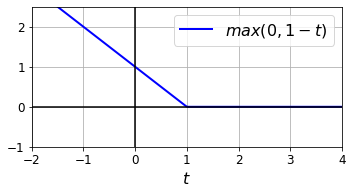

In [ ]:
t = np.linspace(-2, 4, 200)
h = np.where(1 - t < 0, 0, 1 - t)  # max(0, 1-t)

plt.figure(figsize=(5,2.8))
plt.plot(t, h, "b-", linewidth=2, label="$max(0, 1 - t)$")
plt.grid(True, which='both')
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.yticks(np.arange(-1, 2.5, 1))
plt.xlabel("$t$", fontsize=16)
plt.axis([-2, 4, -1, 2.5])
plt.legend(loc="upper right", fontsize=16)
save_fig("hinge_plot")
plt.show()

# 추가 내용

## 훈련 시간

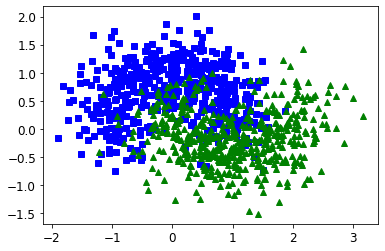

In [ ]:
X, y = make_moons(n_samples=1000, noise=0.4, random_state=42)
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")

[LibSVM]......................................
*.......................
*..............................................................
*...................................*.......................................................*
optimization finished, #iter = 212105
obj = -4447.997680, rho = 0.075931
nSV = 449, nBSV = 441
Total nSV = 449
0 0.1 0.7381584644317627
[LibSVM]................................................*..........................................................*..............*..............................................................*..................................................................*...........*
optimization finished, #iter = 258151
obj = -4448.479655, rho = 0.058653
nSV = 446, nBSV = 441
Total nSV = 446
1 0.01 0.7186133861541748
[LibSVM]...................................................*......*............................................................*..............................................................................*................

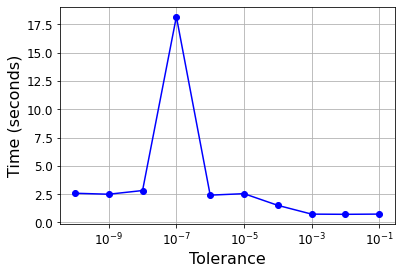

In [ ]:
import time

tol = 0.1
tols = []
times = []
for i in range(10):
    svm_clf = SVC(kernel="poly", gamma=3, C=10, tol=tol, verbose=1)
    t1 = time.time()
    svm_clf.fit(X, y)
    t2 = time.time()
    times.append(t2-t1)
    tols.append(tol)
    print(i, tol, t2-t1)
    tol /= 10
plt.semilogx(tols, times, "bo-")
plt.xlabel("Tolerance", fontsize=16)
plt.ylabel("Time (seconds)", fontsize=16)
plt.grid(True)
plt.show()

## 배치 경사 하강법을 사용한 선형 SVM 분류기 구현

In [ ]:
# 훈련 세트
X = iris["data"][:, (2, 3)] # # 꽃잎 길이, 꽃잎 너비
y = (iris["target"] == 2).astype(np.float64).reshape(-1, 1) # Iris virginica

In [ ]:
from sklearn.base import BaseEstimator

class MyLinearSVC(BaseEstimator):
    def __init__(self, C=1, eta0=1, eta_d=10000, n_epochs=1000, random_state=None):
        self.C = C
        self.eta0 = eta0
        self.n_epochs = n_epochs
        self.random_state = random_state
        self.eta_d = eta_d

    def eta(self, epoch):
        return self.eta0 / (epoch + self.eta_d)
        
    def fit(self, X, y):
        # Random initialization
        if self.random_state:
            np.random.seed(self.random_state)
        w = np.random.randn(X.shape[1], 1) # n feature weights
        b = 0

        m = len(X)
        t = y * 2 - 1  # -1 if y==0, +1 if y==1
        X_t = X * t
        self.Js=[]

        # Training
        for epoch in range(self.n_epochs):
            support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
            X_t_sv = X_t[support_vectors_idx]
            t_sv = t[support_vectors_idx]

            J = 1/2 * np.sum(w * w) + self.C * (np.sum(1 - X_t_sv.dot(w)) - b * np.sum(t_sv))
            self.Js.append(J)

            w_gradient_vector = w - self.C * np.sum(X_t_sv, axis=0).reshape(-1, 1)
            b_derivative = -self.C * np.sum(t_sv)
                
            w = w - self.eta(epoch) * w_gradient_vector
            b = b - self.eta(epoch) * b_derivative
            

        self.intercept_ = np.array([b])
        self.coef_ = np.array([w])
        support_vectors_idx = (X_t.dot(w) + t * b < 1).ravel()
        self.support_vectors_ = X[support_vectors_idx]
        return self

    def decision_function(self, X):
        return X.dot(self.coef_[0]) + self.intercept_[0]

    def predict(self, X):
        return (self.decision_function(X) >= 0).astype(np.float64)

C=2
svm_clf = MyLinearSVC(C=C, eta0 = 10, eta_d = 1000, n_epochs=60000, random_state=2)
svm_clf.fit(X, y)
svm_clf.predict(np.array([[5, 2], [4, 1]]))

array([[1.],
       [0.]])

(0.0, 60000.0, 0.0, 100.0)

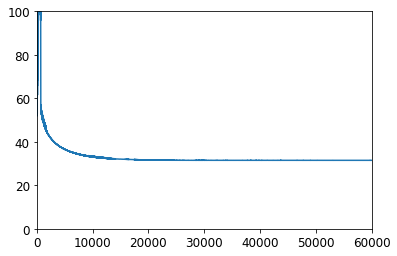

In [ ]:
plt.plot(range(svm_clf.n_epochs), svm_clf.Js)
plt.axis([0, svm_clf.n_epochs, 0, 100])

In [ ]:
print(svm_clf.intercept_, svm_clf.coef_)

[-15.56761653] [[[2.28120287]
  [2.71621742]]]


In [ ]:
svm_clf2 = SVC(kernel="linear", C=C)
svm_clf2.fit(X, y.ravel())
print(svm_clf2.intercept_, svm_clf2.coef_)

[-15.51721253] [[2.27128546 2.71287145]]


(4.0, 6.0, 0.8, 2.8)

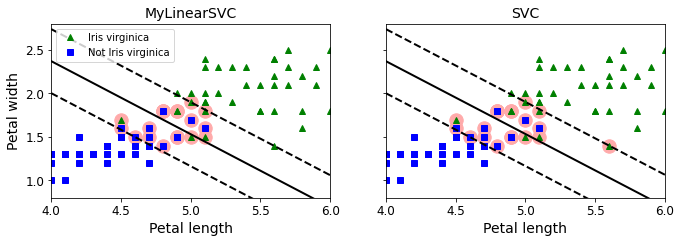

In [ ]:
yr = y.ravel()
fig, axes = plt.subplots(ncols=2, figsize=(11, 3.2), sharey=True)
plt.sca(axes[0])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^", label="Iris virginica")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs", label="Not Iris virginica")
plot_svc_decision_boundary(svm_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("MyLinearSVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])
plt.legend(loc="upper left")

plt.sca(axes[1])
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(svm_clf2, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.title("SVC", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


[-12.52988101   1.94162342   1.84544824]


(4.0, 6.0, 0.8, 2.8)

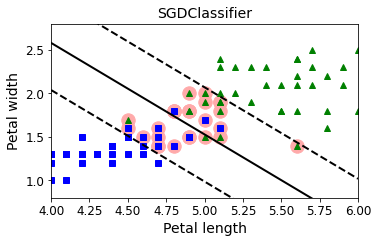

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(loss="hinge", alpha=0.017, max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X, y.ravel())

m = len(X)
t = y * 2 - 1  # y==0이면 -1, y==1이면 +1
X_b = np.c_[np.ones((m, 1)), X]  # 편향 x0=1을 추가합니다
X_b_t = X_b * t
sgd_theta = np.r_[sgd_clf.intercept_[0], sgd_clf.coef_[0]]
print(sgd_theta)
support_vectors_idx = (X_b_t.dot(sgd_theta) < 1).ravel()
sgd_clf.support_vectors_ = X[support_vectors_idx]
sgd_clf.C = C

plt.figure(figsize=(5.5,3.2))
plt.plot(X[:, 0][yr==1], X[:, 1][yr==1], "g^")
plt.plot(X[:, 0][yr==0], X[:, 1][yr==0], "bs")
plot_svc_decision_boundary(sgd_clf, 4, 6)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.title("SGDClassifier", fontsize=14)
plt.axis([4, 6, 0.8, 2.8])


# 연습문제 해답

## 1. to 7.

부록 A 참조.

# 8.

_문제: 선형적으로 분리되는 데이터셋에 `LinearSVC`를 훈련시켜보세요. 그런 다음 같은 데이터셋에 `SVC`와`SGDClassifier`를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요._

Iris 데이터셋을 사용하겠습니다. Iris Setosa와 Iris Versicolor 클래스는 선형적으로 구분이 가능합니다.

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [ ]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


이 3개 모델의 결정 경계를 그려 보겠습니다:

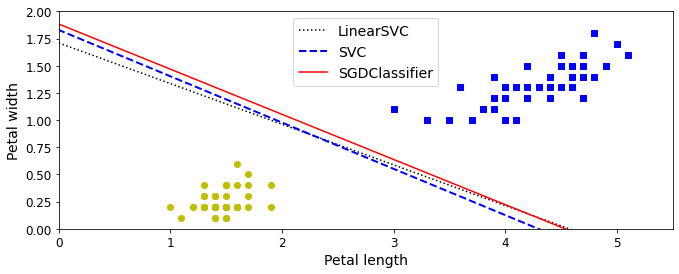

In [ ]:
# 각 결정 경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정 경계를 원본 스케일로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정 경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

아주 비슷하네요!

# 9.

_문제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?_

먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눕니다. `train_test_split()` 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

많은 훈련 알고리즘은 훈련 샘플의 순서에 민감하므로 먼저 이를 섞는 것이 좋은 습관입니다. 하지만 이 데이터셋은 이미 섞여있으므로 이렇게 할 필요가 없습니다.

선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다. 간단하네요!

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

/home/haesun/handson-ml2/.env/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=42)

훈련 세트에 대한 예측을 만들어 정확도를 측정해 보겠습니다(최종 모델을 선택해 훈련시킨 것이 아니기 때문에 아직 테스트 세트를 사용해서는 안됩니다):

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

MNIST에서 83.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있습니다:

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [ ]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

/home/haesun/handson-ml2/.env/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVC(random_state=42)

In [ ]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9214

훨씬 나아졌지만(에러율을 절반으로 줄였습니다) 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용해야 합니다. RBF 커널(기본값)로 `SVC`를 적용해 보겠습니다.

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값인 `gamma="scale"`을 지정합니다.

In [ ]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [ ]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

아주 좋네요 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻었습니다. 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보겠습니다. 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하겠습니다:

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.3s
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.3s
[CV] END ....C=5.847490967837556, gamma=0.004375955271336425; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.544266730893301, gamma=0.024987648190235304; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END ....C=2.199505425963898, gamma=0.009340106304825553; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329656504133618; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329656504133618; total time=   0.3s
[CV] END .....C=7.327377306009368, gamma=0.04329

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5ef8237d68>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5ef82379b0>},
                   verbose=2)

In [ ]:
rnd_search_cv.best_estimator_

SVC(C=3.8786881587000437, gamma=0.0017076019229344522)

In [ ]:
rnd_search_cv.best_score_

0.8599947252641863

이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련시켜 보겠습니다:

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 몇 시간이 걸릴 수 있습니다.

In [ ]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=3.8786881587000437, gamma=0.0017076019229344522)

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9978166666666667

아주 훌륭하네요! 이 모델을 선택하겠습니다. 이제 테스트 세트로 모델을 테스트합니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9717

아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 하이퍼파라미터를 조금 더 수정할 수 있지만(가령, `C`와/나 `gamma`를 감소시킵니다) 그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 다른 사람들은 하이퍼파라미터 `C=5`와 `gamma=0.005`에서 더 나은 성능(98% 이상의 정확도)을 얻었습니다. 훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모릅니다.

## 10.

_문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요._

사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터셋을 로드합니다:

In [ ]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

훈련 세트와 테스트 세트로 나눕니다:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터의 스케일을 조정하는 것을 잊지 마세요:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

먼저 간단한 `LinearSVR`을 훈련시켜 보죠:

In [ ]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

/home/haesun/handson-ml2/.env/lib/python3.7/site-packages/sklearn/svm/_base.py:1201: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


LinearSVR(random_state=42)

훈련 세트에 대한 성능을 확인해 보겠습니다:

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948642

RMSE를 확인해 보겠습니다:

In [ ]:
np.sqrt(mse)

0.9819256687727764

훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다(에러가 클수록 큰 폭으로 증가합니다). 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 썩 훌륭하지 않네요. RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 `C`와 `gamma`의 적절한 값을 찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  20.6s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  19.0s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  19.1s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  18.2s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  17.5s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  16.8s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  17.4s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  16.9s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  17.4s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  16.6s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  22.3s
[CV] END ....C=1.5808361216819946, gamma=0.05399

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5ef9023a20>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f5ef5bce8d0>},
                   random_state=42, verbose=2)

In [ ]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, gamma=0.07969454818643928)

이제 훈련 세트에서 RMSE를 측정해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785358

선형 모델보다 훨씬 나아졌네요. 이 모델을 선택하고 테스트 세트에서 평가해 보겠습니다:

In [ ]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528742